# Regression Discontinuity Designを用いて効果検証を行う

In [1]:
%%capture
#!pip install rdrobust
#!pip install rddensity

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import polars.selectors as cs
pl.Config(fmt_str_lengths = 100, tbl_cols = 100, tbl_rows = 10)
import rddensity
from rdrobust import rdbwselect, rdplot, rdrobust

URL_COUPON = "https://raw.githubusercontent.com/HirotakeIto/intro_to_impact_evaluation_with_python/main/data/ch5_coupon.csv"
URL_COUPON_V2 = "https://raw.githubusercontent.com/HirotakeIto/intro_to_impact_evaluation_with_python/main/data/ch5_coupon_v2.csv"

## 5.1 RDDが適用できるシチュエーション
### 5.1.1 クーポン配布施策：クーポンの効果は本当に大きいのか？
#### 太郎くんの分析を再現するコード

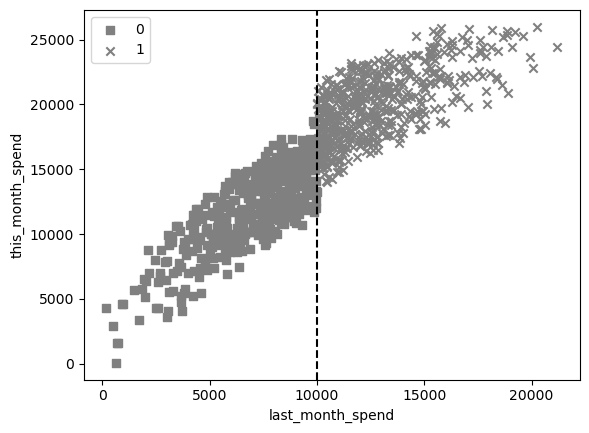

In [3]:
# データの読み込み
df_coupon = pl.read_csv(URL_COUPON)
# 処置ごとの今月消費額の計算
df_coupon.group_by("treatment").agg(pl.mean("this_month_spend"))
# ラベルごとにデータを分ける
df_label0 = df_coupon.filter(pl.col("treatment") == 0)
df_label1 = df_coupon.filter(pl.col("treatment") == 1)
# 散布図の作成
fig, ax = plt.subplots()
ax.scatter(
    df_label0["last_month_spend"],
    df_label0["this_month_spend"],
    c="gray",
    label="0",
    marker="s",
)
ax.scatter(
    df_label1["last_month_spend"],
    df_label1["this_month_spend"],
    c="gray",
    label="1",
    marker="x",
)
threshold = 10000
ax.axvline(x = threshold, color="black", linestyle="--")
# 軸ラベルと凡例の追加
ax.set_xlabel("last_month_spend")
ax.set_ylabel("this_month_spend")
ax.legend()
# グラフの表示
plt.show()

In [4]:
display(df_coupon.head())

last_month_spend,this_month_spend,sex,age,treatment
i64,i64,i64,i64,i64
11900,17185,0,78,1
11621,22057,0,67,1
7236,10703,0,31,0
10501,17589,1,47,1
11284,17804,1,59,1


#### 今月の売り上げの集計

In [5]:
# 処置ごとの今月消費額の計算
df_coupon.group_by("treatment").agg(pl.mean("this_month_spend"))

treatment,this_month_spend
i64,f64
0,11868.546414
1,19956.193916


#### 先月と今月の売り上げの集計

In [6]:
df_coupon.head()

last_month_spend,this_month_spend,sex,age,treatment
i64,i64,i64,i64,i64
11900,17185,0,78,1
11621,22057,0,67,1
7236,10703,0,31,0
10501,17589,1,47,1
11284,17804,1,59,1


In [9]:
# 処置ごとの先月消費額と今月消費額の計算
df_coupon.group_by("treatment").mean().sort("treatment")

treatment,last_month_spend,this_month_spend,sex,age
i64,f64,f64,f64,f64
0,6888.599156,11868.546414,0.331224,49.116034
1,12728.73384,19956.193916,0.363118,48.870722


## 5.2 Sharp RDDの仮定と推定
### 5.2.4 rdrobustパッケージを用いたSharpRDDの推定の実装
#### プログラム5.1 SharpRDDの推定
書籍上では次のようなコードになっています。

```python
import pandas as pd
from rdrobust import rdbwselect, rdplot, rdrobust

# データの読み込み
df_coupon= pd.read_csv(URL_COUPON)
# 推定
result_rdd = rdrobust(
    y=df_coupon.this_month_spend,
    x=df_coupon.last_month_spend,
    c=10000,
    all=True,
)
# プロット
rdplot(
    y=df_coupon.this_month_spend,
    x=df_coupon.last_month_spend,
    binselect="es",
    c=10000,
    ci=95,
    title="Causal Effects of Coupons",
    y_label="this_month_spend",
    x_label="last_month_spend",
)
```

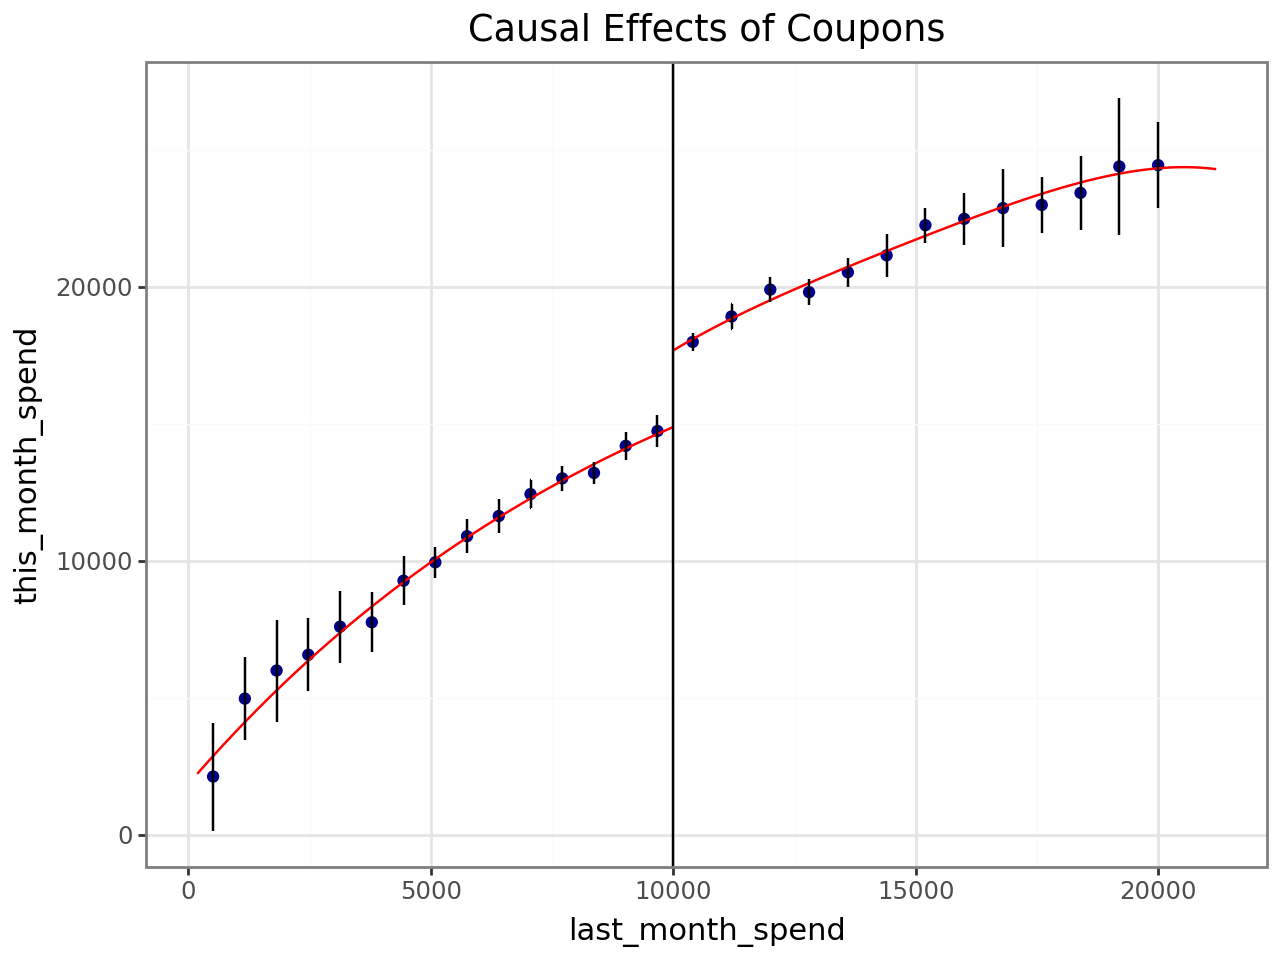


Call: rdplot
Number of Observations:                  1000
Kernel:                               Uniform
Polynomial Order Est. (p):                  4

                                Left      Right
------------------------------------------------
Number of Observations           474        526
Number of Effective Obs          474        526
Bandwith poly. fit (h)          9818      11196
Number of bins scale               1          1
Bins Selected                     15         14
Average Bin Length           654.533    799.714
Median Bin Length            654.533    799.714
IMSE-optimal bins               15.0       14.0
Mimicking Variance bins         61.0       46.0

Relative to IMSE-optimal:
Implied scale                    1.0        1.0
WIMSE variance weight            0.5        0.5
WIMSE bias weight                0.5        0.5


In [11]:
# データの読み込み
df_coupon = pl.read_csv(URL_COUPON)
# 推定
result_rdd = rdrobust(
    y=df_coupon["this_month_spend"],
    x=df_coupon["last_month_spend"],
    c=10000,
    all=True,
)
# プロット
rdplot(
    y=df_coupon["this_month_spend"],
    x=df_coupon["last_month_spend"],
    binselect="es",
    c=10000,
    ci=95,
    title="Causal Effects of Coupons",
    y_label="this_month_spend",
    x_label="last_month_spend",
)

In [12]:
result_rdd

Call: rdrobust
Number of Observations:                  1000
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations           474        526
Number of Unique Obs.            457        508
Number of Effective Obs.         275        344
Bandwidth Estimation         3142.14    3142.14
Bandwidth Bias              5102.166   5102.166
rho (h/b)                      0.616      0.616

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional    2751.558  362.121    7.598   2.997e-14 [2041.813, 3461.303]
Bias-Corrected   2709.09  362.121    7.481   7.367e-14 [1999.345, 3418.835]
Robust           2709.09 

### 5.2.6 McCraryの検定の実装
#### プログラム5.2 McCrary の検定（プログラム5.1 の続き）
書籍上では次のようなコードになっています。

```python
import matplotlib.pyplot as plt
import pandas as pd
import rddensity

# データの読み込み
df_coupon= pd.read_csv(URL_COUPON)
## ヒストグラムのプロット
plt.hist(df_coupon.last_month_spend, range=(9000, 11000))
# グラフの表示
plt.show()
# McCraryの検定
result_mccrary = rddensity.rddensity(X=df_coupon.last_month_spend, c = 10000)
```

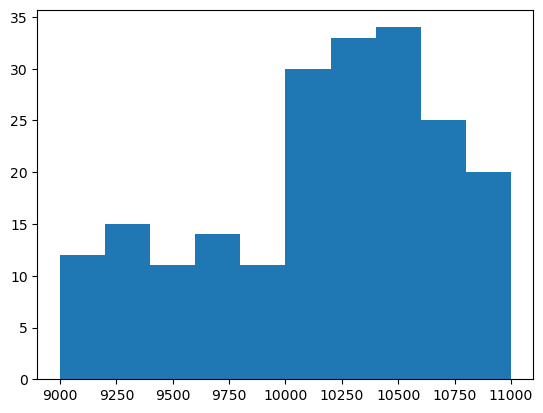

In [13]:
# データの読み込み
df_coupon = pl.read_csv(URL_COUPON)
## ヒストグラムのプロット
plt.hist(df_coupon["last_month_spend"], range=(9000, 11000))
# グラフの表示
plt.show()
# McCraryの検定
result_mccrary = rddensity.rddensity(
    X=df_coupon["last_month_spend"], c=10000
)

In [14]:
display(result_mccrary)

Manipulation testing using local polynomial density estimation
Number of obs:                              1000
Model:                              unrestricted
Kernel:                               triangular
BW method:                             estimated
VCE:                                   jackknife

c = 10000                           Left of c             Right of c
Number of obs:                            474                    526
Eff. number of obs:                       126                    234
Order est. (p):                             2                      2
Order bias. (q):                            3                      3
BW est.                             1654.8133              1946.1021

Method:                                     T                P > |T|
Robust                                  3.328                 0.0009

P-values of binomial tests (H0: p =  [0.5] ).

Window Length/2                           < c                     >= c                    

### 5.2.7共変量のバランステストの実装
#### プログラム5.3 共変量のバランステスト
書籍上では次のようなコードになっています。

```python
import pandas as pd

# データの読み込み
df_coupon = pd.read_csv(URL_COUPON)
# バランステストの結果を格納するデータフレームの作成
covs = df_coupon[["sex", "age"]]
balance = pd.DataFrame(
    columns=["RD Effect", "Robust p-val"],
    index=pd.Index(["sex", "age"]),
)
# バランステスト
for z in covs.columns:
    est = rdrobust(y=covs[z], x=df_coupon.last_month_spend, c=10000)
    balance.loc[z, "RD Effect"] = est.Estimate["tau.us"].values[0]
    balance.loc[z, "Robust p-val"] = est.pv.iloc[2].values[0]
# 結果の表示
display(balance)
```

In [15]:
# データの読み込み
df_coupon = pl.read_csv(URL_COUPON).to_pandas()
# バランステストの結果を格納するデータフレームの作成
covs = df_coupon[["sex", "age"]]
# マルチインデックスはpandasのみのため、仕方なくpandasを読み込む
import pandas as pd
balance = pd.DataFrame(
    columns=["RD Effect", "Robust p-val"],
    index=pd.Index(["sex", "age"]),
)
# バランステスト
for z in covs.columns:
    est = rdrobust(y=covs[z], x=df_coupon.last_month_spend, c=10000)
    balance.loc[z, "RD Effect"] = est.Estimate["tau.us"].values[0]
    balance.loc[z, "Robust p-val"] = est.pv.iloc[2].values[0]
# 結果の表示
display(balance)

,RD Effect,Robust p-val
sex,0.010663,0.929465
age,0.667869,0.978184


## 5.3 Fuzzy RDD
### 5.3.1 rdrobustパッケージを用いたFuzzyRDDの推定の実装
#### プログラム5.4 Fuzzy RDD の推定
書籍上では次のようなコードになっています。

```python
import pandas as pd
from rdrobust import rdrobust

# データの読み込み
df_coupon= pd.read_csv(URL_COUPON_V2)
# ラベルごとにデータを分ける
df_label0 = df_coupon[df_coupon["treatment"] == 0]
df_label1 = df_coupon[df_coupon["treatment"] == 1]
# 散布図の作成
fig, ax = plt.subplots()
ax.scatter(
    df_label0["last_month_spend"],
    df_label0["this_month_spend"],
    c="gray",
    label="0",
    marker="s",
)
ax.scatter(
    df_label1["last_month_spend"],
    df_label1["this_month_spend"],
    c="gray",
    label="1",
    marker="x",
)
threshold = 10000
ax.axvline(x=threshold, color="black", linestyle="--")
# 軸ラベルと凡例の追加
ax.set_xlabel("last_month_spend")
ax.set_ylabel("this_month_spend")
ax.legend()
# グラフの表示
plt.show()
# 推定
result_fuzzy_rdd = rdrobust(y=df_coupon.this_month_spend, x=df_coupon.last_month_spend, fuzzy= df_coupon.treatment, c = 10000, all=True)
```

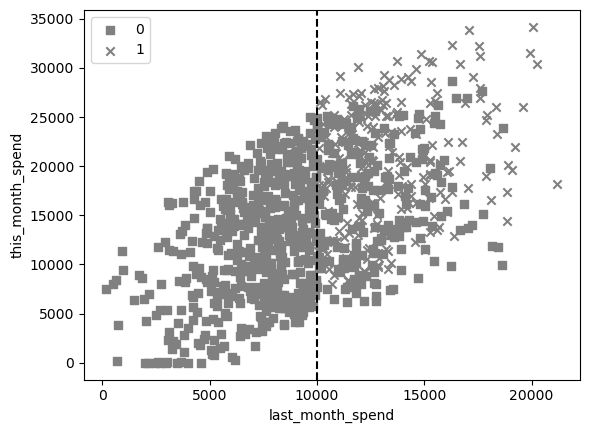

In [18]:
# データの読み込み
df_coupon = pl.read_csv(URL_COUPON_V2)
# ラベルごとにデータを分ける
df_label0 = df_coupon.filter(pl.col("treatment") == 0)
df_label1 = df_coupon.filter(pl.col("treatment") == 1)
# 散布図の作成
fig, ax = plt.subplots()
ax.scatter(
    df_label0["last_month_spend"],
    df_label0["this_month_spend"],
    c="gray",
    label="0",
    marker="s",
)
ax.scatter(
    df_label1["last_month_spend"],
    df_label1["this_month_spend"],
    c="gray",
    label="1",
    marker="x",
)
threshold = 10000
ax.axvline(x=threshold, color="black", linestyle="--")
# 軸ラベルと凡例の追加
ax.set_xlabel("last_month_spend")
ax.set_ylabel("this_month_spend")
ax.legend()
# グラフの表示
plt.show()
# 推定
result_fuzzy_rdd = rdrobust(
    y=df_coupon["this_month_spend"],
    x=df_coupon["last_month_spend"],
    fuzzy=df_coupon["treatment"],
    c=10000,
    all=True,
)

In [19]:
display(df_coupon.head())

last_month_spend,this_month_spend,treatment
i64,i64,i64
11900,21241,0
11621,23249,1
7236,12473,0
10501,18700,1
11284,9825,1


In [20]:
display(result_fuzzy_rdd)

Call: rdrobust
Number of Observations:                  1000
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations           528        472
Number of Unique Obs.            505        462
Number of Effective Obs.         258        219
Bandwidth Estimation        2316.136   2316.136
Bandwidth Bias               3543.11    3543.11
rho (h/b)                      0.654      0.654

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional    6531.203 2645.704    2.469   1.356e-02 [1345.719, 11716.687]
Bias-Corrected  6671.428 2645.704    2.522   1.168e-02 [1485.944, 11856.912]
Robust          6671.42

In [21]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu Jun 13 2024

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.22.2

matplotlib: 3.8.4
pandas    : 2.2.2
rddensity : 2.4.4
numpy     : 1.26.4
polars    : 0.20.31

Watermark: 2.4.3

